# Statistics and Visualisations

In [36]:
from tools import load_settings
settings = load_settings()
NAME = settings["NAME"]

In [37]:
import pickle
from scipy.stats import ttest_ind
import pandas as pd
from eventstudystatistics import grank, adjBMP
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
# set logging to warning
import logging
logging.getLogger().setLevel(logging.WARNING)
# unpickle the abnormal returns
df_abnormal_returns = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_abnormal_returns.pkl")

# set plotting sizes
tick_size = 15
label_size = 20
title_size = 30
fig_height = 20

EVENT_INDEX = 0

investigation_periods = settings["investigation_periods"]

day_labels = np.asarray(list(range(settings["L2"]))) - (settings["L2"]-1)/2

CAR_repr = lambda x: str([x[0]-(settings["L2"]-1)/2, x[1]-(settings["L2"]-1)/2])
CAR_periods = settings["CAR_periods"]
event_day = settings["event_day"]

with open(f"data/{NAME}/calculate_AR_results/companies.pkl", "rb") as f:
    companies = pickle.load(f)


### Having a look at all trade types together

In [38]:
types_of_interest = settings["types_of_interest"]
counts = df_abnormal_returns.groupby(level=2).count()[0].rename({0: "N"})
print(f"relevant filings: ",counts[types_of_interest].sum())
print(counts[types_of_interest])
print(f"dropped filings ", counts.sum() - counts[types_of_interest].sum())

relevant filings:  69214
TradeType
P - Purchase    16429
S - Sale        30506
S - Sale+OE     22279
Name: 0, dtype: int64
dropped filings  210986


In [39]:
# enable multiindex slicing
df_abnormal_returns.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)

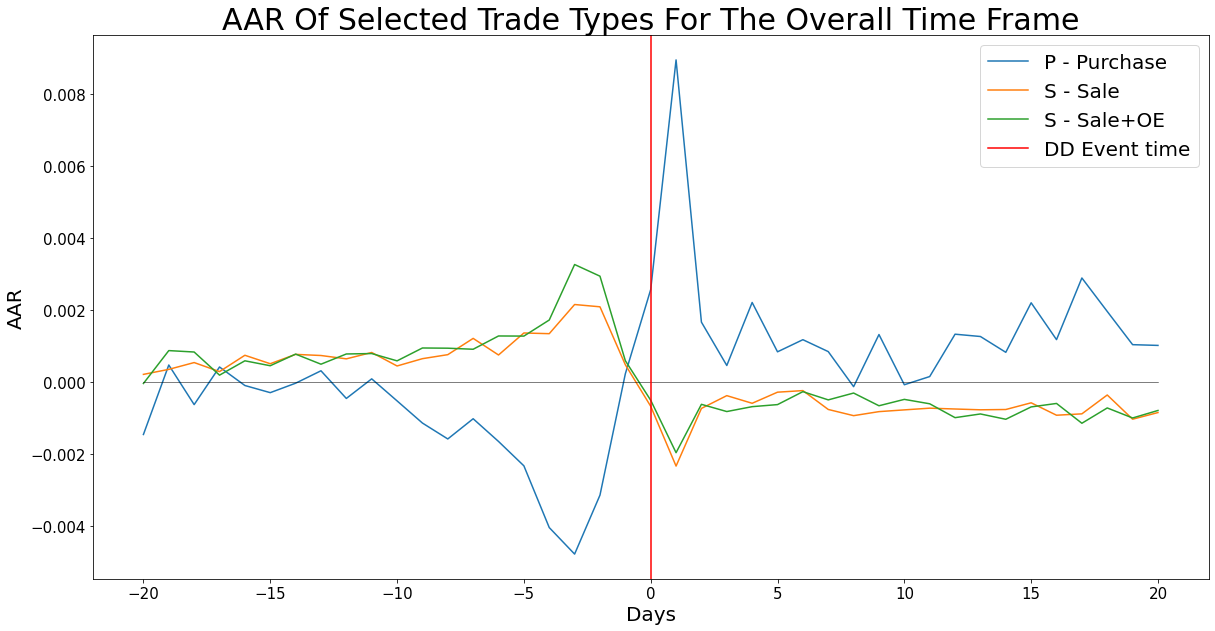

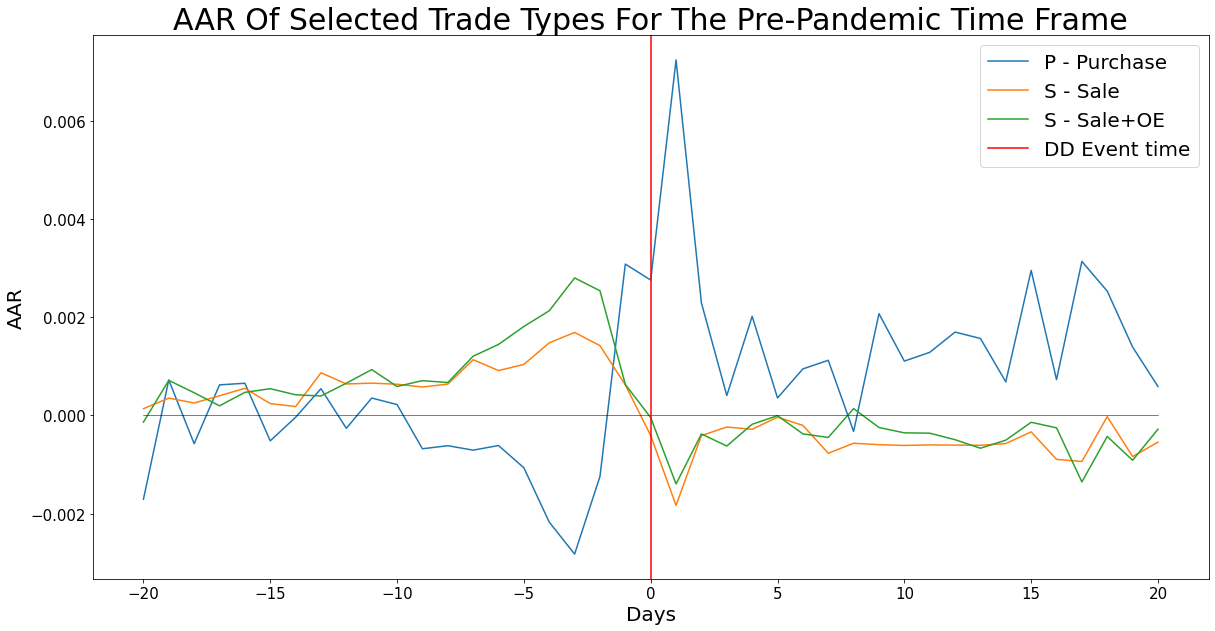

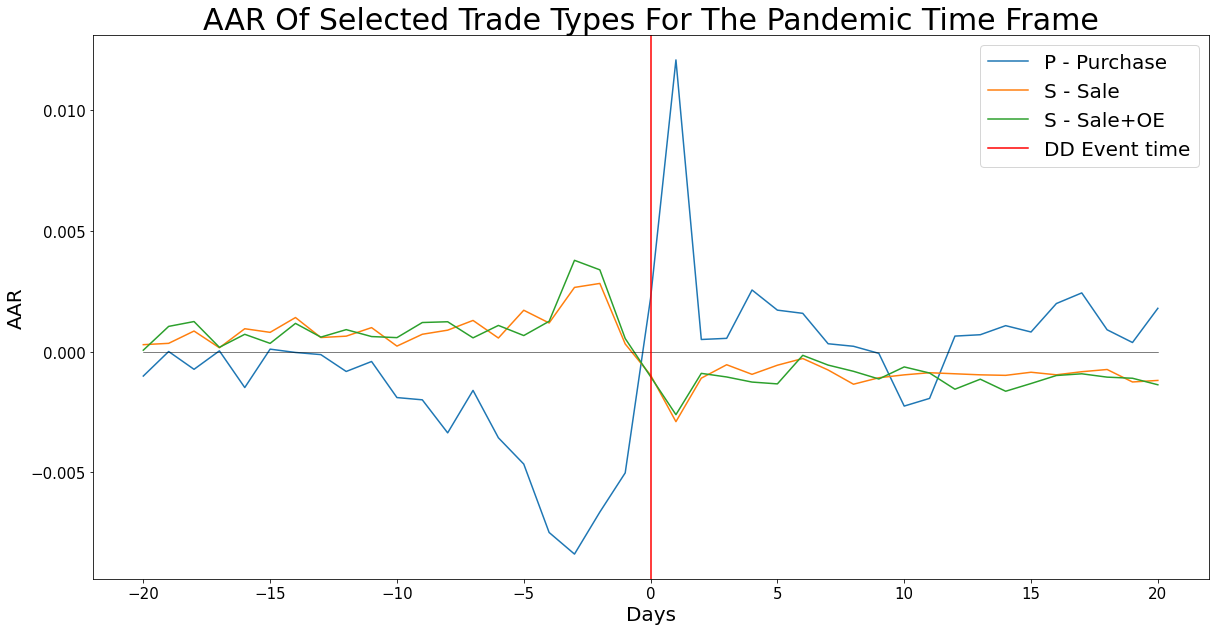

In [40]:
for investigation_period, (start, end) in investigation_periods.items():
    a = df_abnormal_returns.loc[:,:,types_of_interest,start:end].groupby(level=[2]).mean().transpose().set_index(day_labels).plot(figsize=(fig_height, 10))
    plt.plot(day_labels, np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
    a.set_title(f"AAR Of Selected Trade Types For The {investigation_period} Time Frame",fontsize=title_size)

    a.set_xlabel("Days", fontsize=label_size)
    a.set_ylabel("AAR", fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
    plt.legend(fontsize=label_size)
    plt.savefig(f"data/{NAME}/visualisations/AAR_selected_tradetypes_{investigation_period}.svg", dpi=600, bbox_inches='tight')

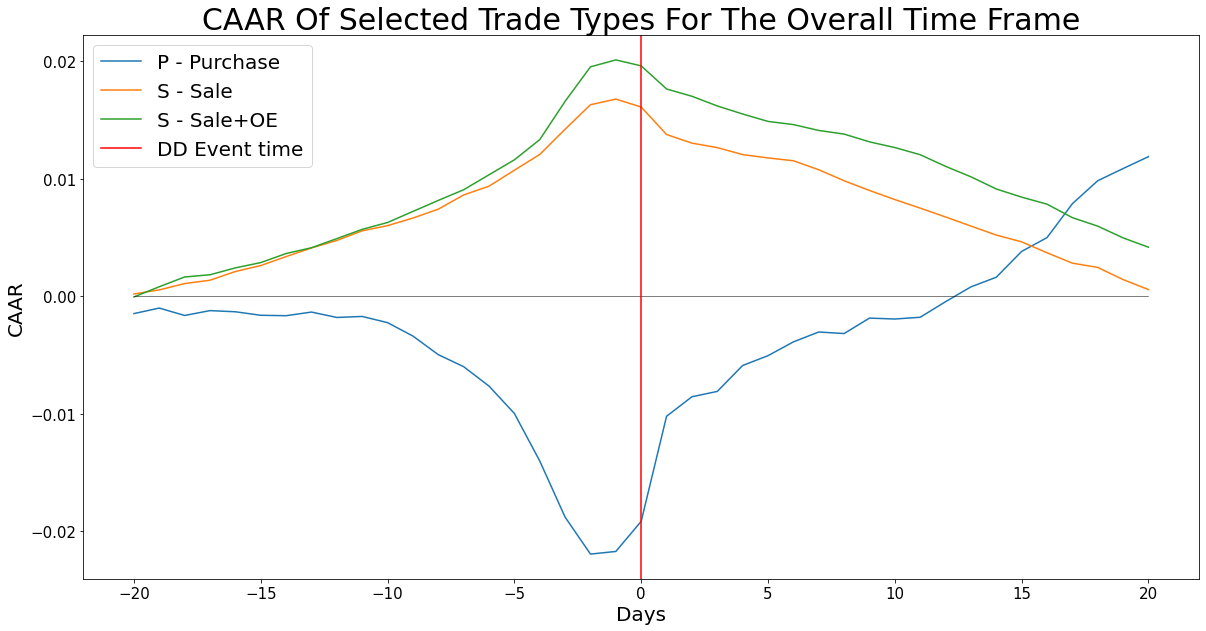

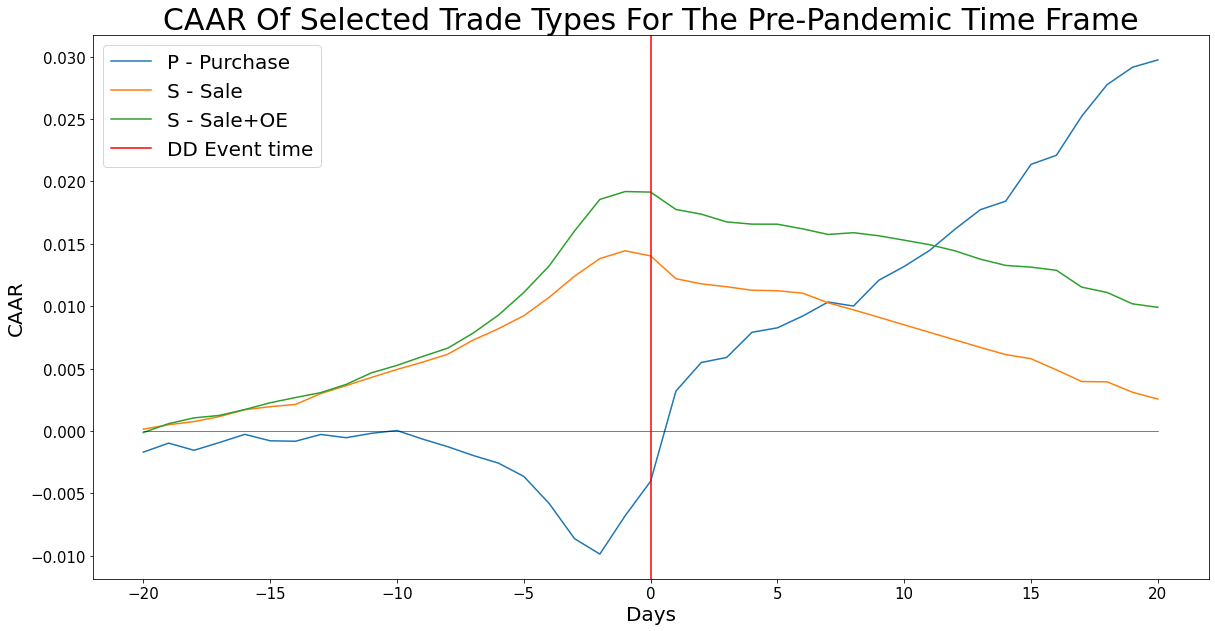

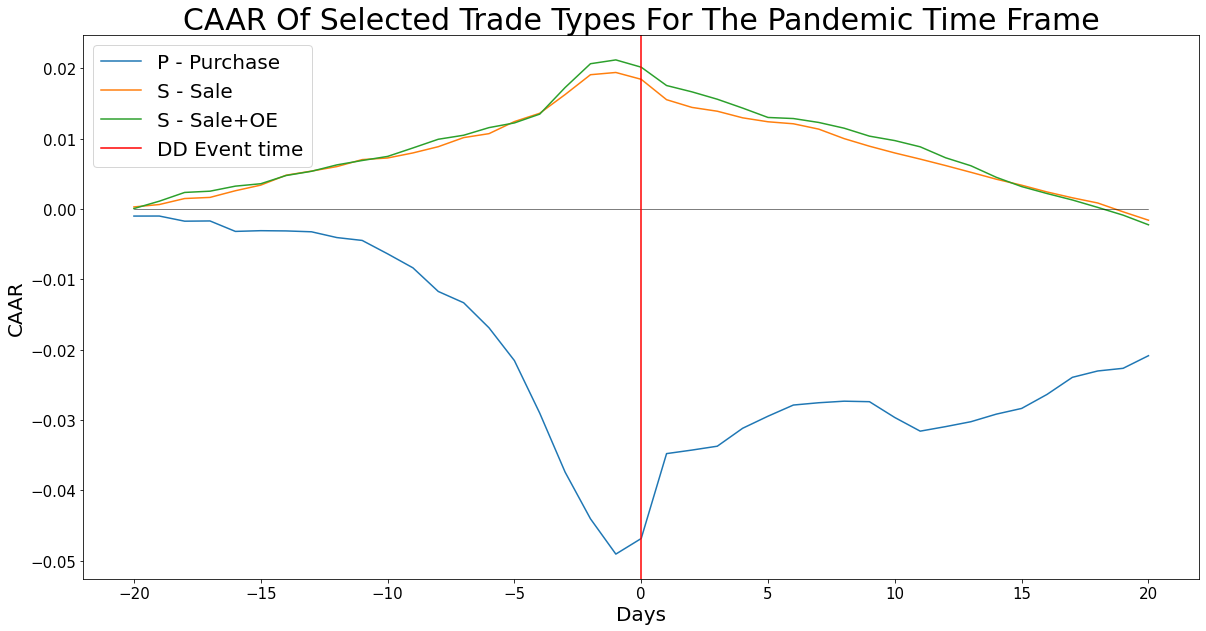

In [41]:
for investigation_period, (start, end) in investigation_periods.items():
    a = df_abnormal_returns.loc[:,:,types_of_interest,start:end].cumsum(axis=1).groupby(level=[2]).mean().transpose().set_index(day_labels).plot(figsize=(fig_height, 10))
    plt.plot(day_labels, np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
    a.set_title(f"CAAR Of Selected Trade Types For The {investigation_period} Time Frame",fontsize=title_size)
    a.set_xlabel("Days", fontsize=label_size)
    a.set_ylabel("CAAR", fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
    plt.legend(fontsize=label_size)
    plt.savefig(f"data/{NAME}/visualisations/CAAR_selected_tradetypes_{investigation_period}.svg", dpi=600, bbox_inches='tight')

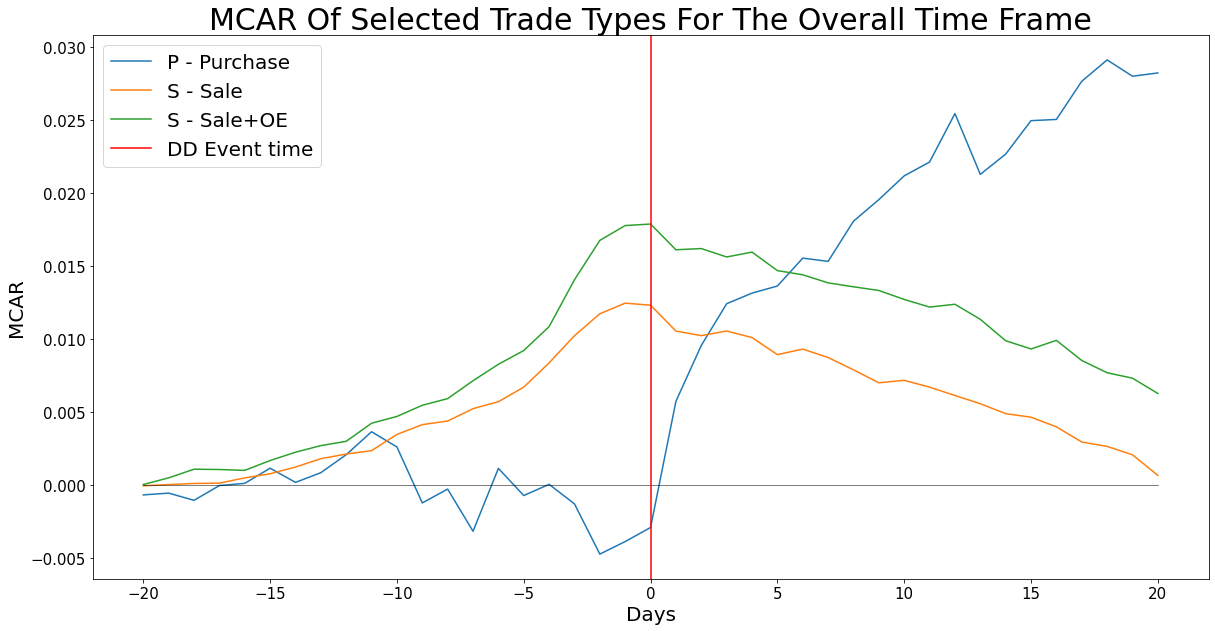

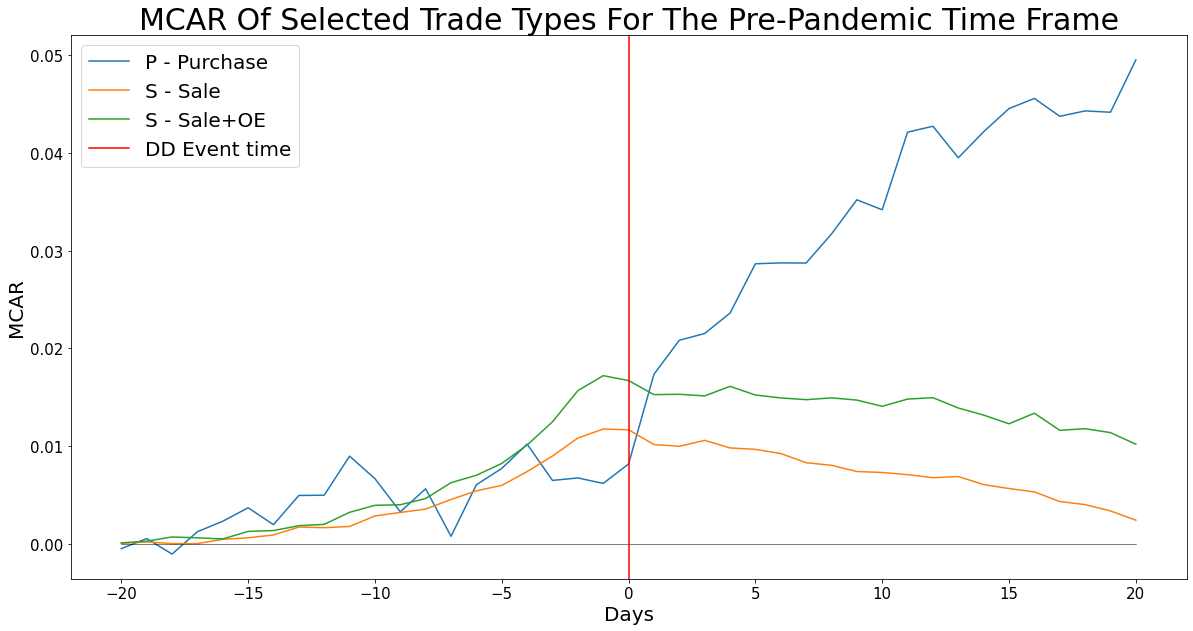

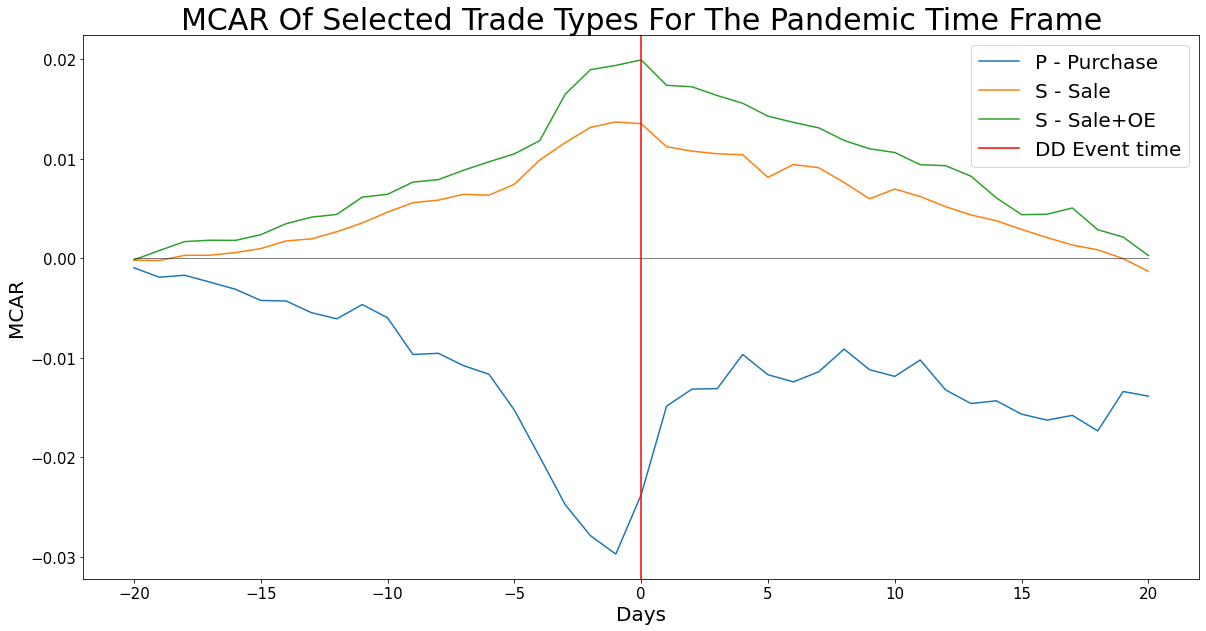

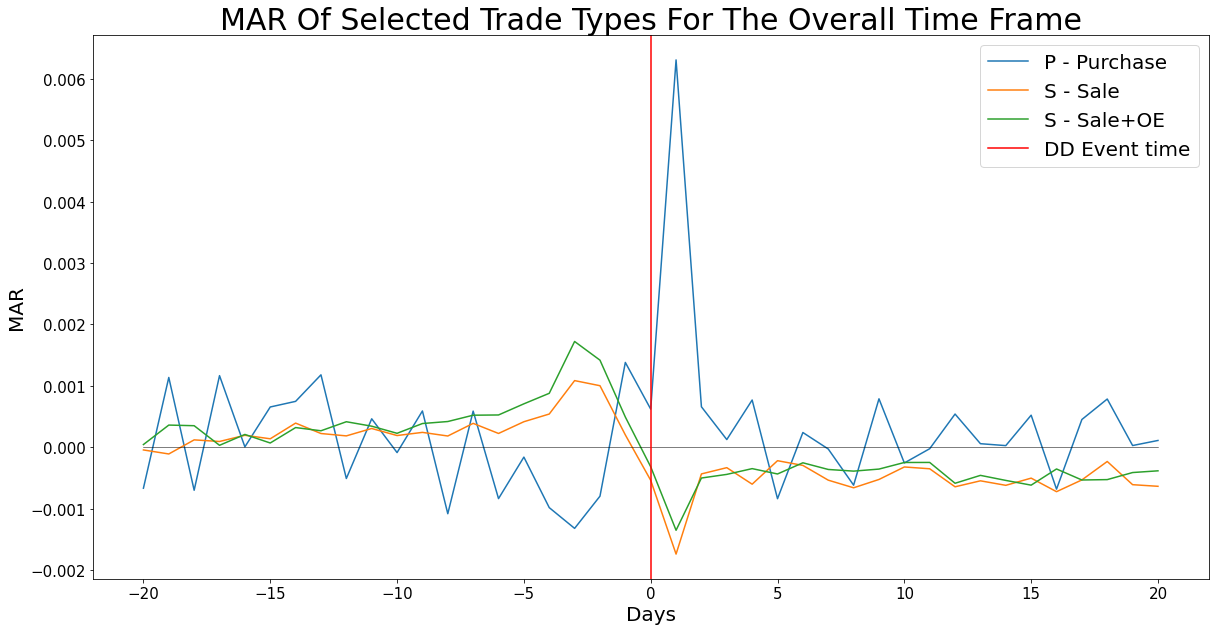

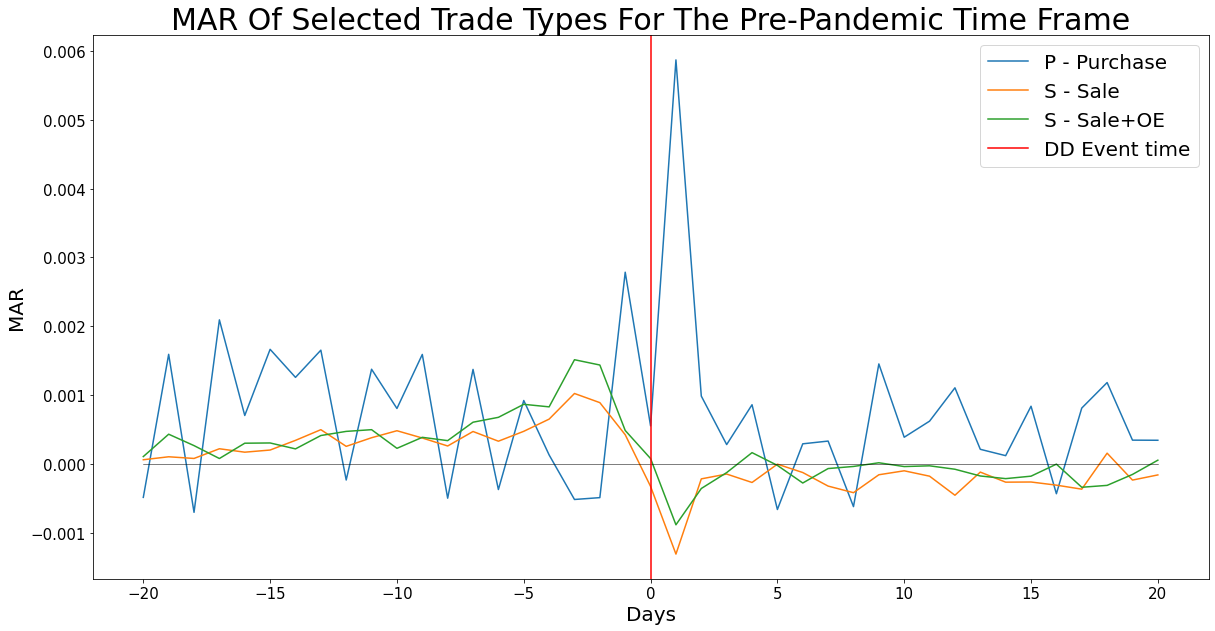

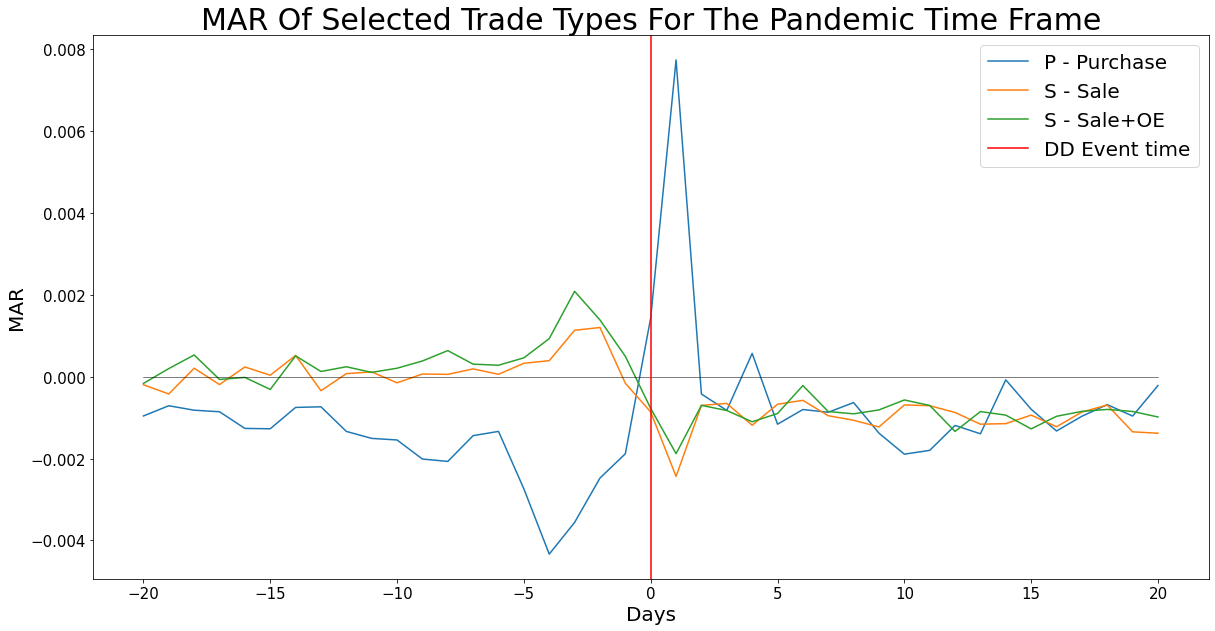

In [42]:
for investigation_period, (start, end) in investigation_periods.items():
    a = df_abnormal_returns.loc[:,:,types_of_interest,start:end].cumsum(axis=1).groupby(level=[2]).median().transpose().set_index(day_labels).plot(figsize=(fig_height, 10))
    plt.plot(day_labels, np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
    a.set_title(f"MCAR Of Selected Trade Types For The {investigation_period} Time Frame",fontsize=title_size)
    a.set_xlabel("Days", fontsize=label_size)
    a.set_ylabel("MCAR", fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
    plt.legend(fontsize=label_size)
    plt.savefig(f"data/{NAME}/visualisations/CMAR_selected_tradetypes_{investigation_period}.svg", dpi=600, bbox_inches='tight')

for investigation_period, (start, end) in investigation_periods.items():
    a = df_abnormal_returns.loc[:,:,types_of_interest,start:end].groupby(level=[2]).median().transpose().set_index(day_labels).plot(figsize=(fig_height, 10))
    plt.plot(day_labels, np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
    a.set_title(f"MAR Of Selected Trade Types For The {investigation_period} Time Frame",fontsize=title_size)
    a.set_xlabel("Days", fontsize=label_size)
    a.set_ylabel("MAR", fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
    plt.legend(fontsize=label_size)
    plt.savefig(f"data/{NAME}/visualisations/MAR_selected_tradetypes_{investigation_period}.svg", dpi=600, bbox_inches='tight')

In [43]:
df_abnormal_returns

0         1         2         3   \
Company i  TradeType event_timestamp                                           
A       2  S - Sale  2021-12-30      -0.012152  0.007386 -0.007207  0.006358   
        3  S - Sale  2021-12-21      -0.009360 -0.052116 -0.013611  0.006317   
        6  G - Gift  2021-12-17       0.005563  0.017338 -0.009051 -0.051981   
        7  S - Sale  2021-12-17       0.005563  0.017338 -0.009051 -0.051981   
        8  S - Sale  2021-12-06      -0.010824  0.026151 -0.007095 -0.001398   
...                                        ...       ...       ...       ...   
ZYME    77 S - Sale  2018-08-31      -0.001355  0.041336  0.032368 -0.021877   
        78 S - Sale  2018-08-16      -0.026529 -0.058754 -0.012507 -0.026825   
        79 S - Sale  2018-08-14      -0.005906 -0.035839 -0.026778 -0.058989   
        80 S - Sale  2018-08-07      -0.019061 -0.001864 -0.002953 -0.002911   
        81 S - Sale  2018-08-03      -0.024830 -0.004142 -0.018787 -0.001851   

                                            4         5         6         7   \
Company i  TradeType event_timestamp                                           
A       2  S - Sale  2021-12-30       0.006979  0.014670 -0.007495  0.008109   
        3  S - Sale  2021-12-21       0.005939 -0.005570 -0.012643  0.006108   
        6  G - Gift  2021-12-17      -0.013412  0.007379  0.006076 -0.004588   
        7  S - Sale  2021-12-17      -0.013412  0.007379  0.006076 -0.004588   
        8  S - Sale  2021-12-06      -0.004678  0.010050 -0.019655  0.021602   
...                                        ...       ...       ...       ...   
ZYME    77 S - Sale  2018-08-31       0.010527 -0.019758  0.006243 -0.012498   
        78 S - Sale  2018-08-16      -0.016524 -0.000368 -0.027301 -0.023253   
        79 S - Sale  2018-08-14      -0.012743 -0.027045 -0.016733 -0.000599   
        80 S - Sale  2018-08-07      -0.016962 -0.004908 -0.034474 -0.027603   
        81 S - Sale  2018-08-03      -0.002612 -0.002683 -0.016777 -0.004645   

                                            8         9   ...        31  \
Company i  TradeType event_timestamp                      ...             
A       2  S - Sale  2021-12-30       0.004208 -0.026409  ... -0.002370   
        3  S - Sale  2021-12-21      -0.007784  0.005237  ...  0.001087   
        6  G - Gift  2021-12-17      -0.012010  0.005649  ... -0.038211   
        7  S - Sale  2021-12-17      -0.012010  0.005649  ... -0.038211   
        8  S - Sale  2021-12-06       0.003414  0.005254  ...  0.013336   
...                                        ...       ...  ...       ...   
ZYME    77 S - Sale  2018-08-31      -0.008881 -0.000438  ...  0.002322   
        78 S - Sale  2018-08-16       0.007529  0.000006  ... -0.010578   
        79 S - Sale  2018-08-14      -0.027548 -0.023495  ...  0.003887   
        80 S - Sale  2018-08-07      -0.058720 -0.012479  ... -0.019499   
        81 S - Sale  2018-08-03      -0.034191 -0.027441  ... -0.041333   

                                            32        33        34        35  \
Company i  TradeType event_timestamp                                           
A       2  S - Sale  2021-12-30      -0.021205  0.003561 -0.002202 -0.006005   
        3  S - Sale  2021-12-21      -0.028015  0.000596  0.003662  0.016754   
        6  G - Gift  2021-12-17      -0.010414  0.001256 -0.027784  0.000944   
        7  S - Sale  2021-12-17      -0.010414  0.001256 -0.027784  0.000944   
        8  S - Sale  2021-12-06       0.013480  0.003072 -0.000184  0.002246   
...                                        ...       ...       ...       ...   
ZYME    77 S - Sale  2018-08-31       0.053708  0.074366 -0.007598 -0.052357   
        78 S - Sale  2018-08-16      -0.041396  0.018974 -0.001984  0.042338   
        79 S - Sale  2018-08-14      -0.005882 -0.010822 -0.041648  0.018736   
        80 S - Sale  2018-08-07      -0.001970 -0.013695  0.006193  0.005659   
        81 S - Sale  2018-

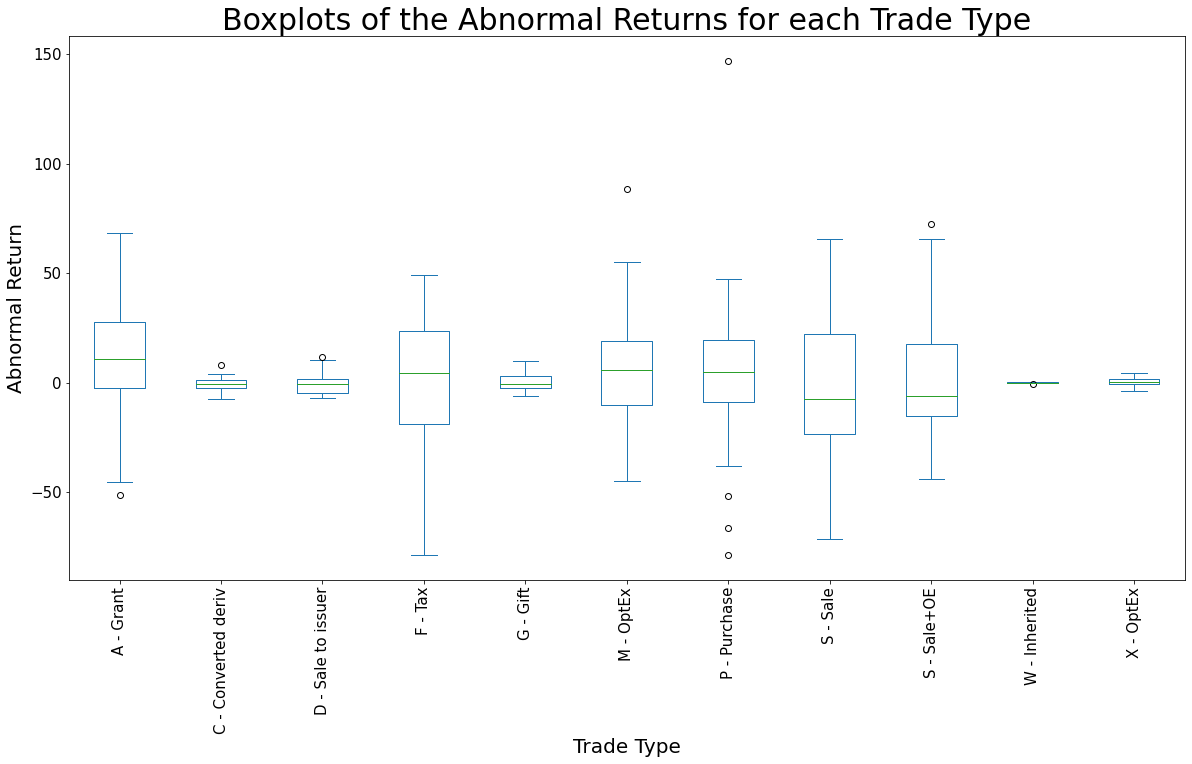

In [44]:
ax = df_abnormal_returns.groupby(level=[2]).sum().transpose().set_index(day_labels).plot.box(rot=90, figsize=(fig_height, 10))
ax.set_title("Boxplots of the Abnormal Returns for each Trade Type",fontsize=title_size)
ax.set_xlabel("Trade Type", fontsize=label_size)
ax.set_ylabel("Abnormal Return", fontsize=label_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.savefig(f"data/{NAME}/visualisations/AR_all_tradetypes_boxplot.svg", dpi=600, bbox_inches='tight')

In [45]:
types = list(set([x[2] for x in df_abnormal_returns.index]))
types

['F - Tax',
 'A - Grant',
 'S - Sale',
 'M - OptEx',
 'G - Gift',
 'D - Sale to issuer',
 'C - Converted deriv',
 'P - Purchase',
 'X - OptEx',
 'S - Sale+OE',
 'W - Inherited']

Specify the type of the trades to investigate

In [46]:
type_ = "P - Purchase" # "S - Sale"
df_abnormal_returns_type = df_abnormal_returns.loc[:,:,type_]

The index describes the company and the index of the filing in the compnay, the columns represent the days in the event window

In [47]:
df_abnormal_returns_type

0         1         2         3         4   \
Company i   event_timestamp                                                     
AA      85  2021-01-28      -0.009691  0.026533 -0.004668  0.028584 -0.007647   
        96  2020-11-18       0.048303  0.005339 -0.024841  0.009477  0.021854   
        97  2020-10-20      -0.017871  0.000492  0.001662 -0.040046  0.018044   
        111 2020-09-18      -0.005682 -0.043191  0.006080 -0.013762 -0.009739   
        112 2020-08-18       0.018392 -0.015857 -0.021402  0.008227  0.025276   
...                               ...       ...       ...       ...       ...   
ZTS     71  2021-02-23      -0.011247 -0.007338 -0.027405  0.015873 -0.004572   
ZWS     334 2019-02-04      -0.015043 -0.005062  0.001130  0.024848  0.007290   
        344 2018-11-02       0.002474 -0.005742 -0.025981 -0.022245 -0.004582   
ZYME    53  2020-04-07      -0.070580 -0.048124 -0.037611 -0.056025 -0.076347   
        54  2020-01-28      -0.015828 -0.002277  0.006228  0.039188 -0.043007   

                                   5         6         7         8         9   \
Company i   event_timestamp                                                     
AA      85  2021-01-28       0.026128 -0.021591 -0.016989 -0.014880  0.009034   
        96  2020-11-18       0.019131  0.013988  0.024911  0.009131 -0.024158   
        97  2020-10-20      -0.033954 -0.025941 -0.028134  0.031012 -0.033492   
        111 2020-09-18      -0.024002 -0.001233 -0.019893  0.017335 -0.056728   
        112 2020-08-18      -0.018055 -0.003332  0.015975 -0.006281  0.041729   
...                               ...       ...       ...       ...       ...   
ZTS     71  2021-02-23       0.001823  0.005879 -0.015824  0.007827  0.010797   
ZWS     334 2019-02-04      -0.010050 -0.015858 -0.007550 -0.004943  0.004333   
        344 2018-11-02      -0.037544  0.015252  0.006202 -0.027930 -0.022597   
ZYME    53  2020-04-07       0.092469 -0.055240  0.052109  0.043787  0.076722   
        54  2020-01-28      -0.024727  0.025046 -0.015101 -0.006017 -0.034816   

                             ...        31        32        33        34  \
Company i   event_timestamp  ...                                           
AA      85  2021-01-28       ...  0.000560  0.026017 -0.021297 -0.023540   
        96  2020-11-18       ...  0.042893 -0.005761 -0.013322 -0.021939   
        97  2020-10-20       ... -0.068731  0.018846  0.021893  0.010325   
        111 2020-09-18       ... -0.025759 -0.009993  0.013452  0.012795   
        112 2020-08-18       ... -0.049346  0.006079  0.016930  0.015471   
...                          ...       ...       ...       ...       ...   
ZTS     71  2021-02-23       ...  0.001747  0.004471 -0.000592  0.013253   
ZWS     334 2019-02-04       ...  0.003047 -0.003422 -0.004152 -0.005546   
        344 2018-11-02       ... -0.018943  0.002923 -0.000575 -0.005807   
ZYME    53  2020-04-07       ... -0.017925  0.023028 -0.030661 -0.033918   
        54  2020-01-28       ... -0.006797 -0.011712 -0.013153 -0.000979   

                                   35        36        37        38        39  \
Company i   event_timestamp                                                     
AA      85  2021-01-28       0.083143  0.073253 -0.000379  0.065464 -0.016858   
        96  2020-11-18       0.052514 -0.043924 -0.026661 -0.012799 -0.029024   
        97  2020-10-20      -0.004100 -0.011539  0.012518  0.018643  0.022395   
        111 2020-09-18      -0.030474 -0.009488  0.021591  0.027040 -0.057837   
        112 2020-08-18      -0.035472 -0.001631  0.004840 -0.016912 -0.024745   
...                               ...       ...       ...       ...       ...   
ZTS     71  2021-02-23       0.005104  0.005643 -0.018974  0.005845  0.017138   
ZWS     334 2019-02-04      -0.014531 -0.003519 -0.014049  0.008942  0.006323   
        344 2018-11-02      -0.012066 -0.015787  0.007498 -0.001151  0.009052   
ZYME    53  2020-04-07      -0.043735  0.011080

In [48]:
df_abnormal_returns.loc[:,:, types_of_interest].groupby(level=[2]).count()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
TradeType,,,,,,,,,,,,,,,,,,,,,
P - Purchase,16429,16429,16429,16429,16429,16429,16429,16429,16429,16429,...,16429,16429,16429,16429,16429,16429,16429,16429,16429,16429
S - Sale,30506,30506,30506,30506,30506,30506,30506,30506,30506,30506,...,30506,30506,30506,30506,30506,30506,30506,30506,30506,30506
S - Sale+OE,22279,22279,22279,22279,22279,22279,22279,22279,22279,22279,...,22279,22279,22279,22279,22279,22279,22279,22279,22279,22279


In [49]:
CAR = df_abnormal_returns.cumsum(axis =1).loc[:,:, types_of_interest]
CAR

0         1         2         3   \
Company i  TradeType event_timestamp                                           
A       2  S - Sale  2021-12-30      -0.012152 -0.004767 -0.011974 -0.005616   
        3  S - Sale  2021-12-21      -0.009360 -0.061475 -0.075087 -0.068770   
        7  S - Sale  2021-12-17       0.005563  0.022901  0.013850 -0.038131   
        8  S - Sale  2021-12-06      -0.010824  0.015327  0.008232  0.006834   
        10 S - Sale  2021-12-02      -0.001448 -0.004636 -0.015566  0.010480   
...                                        ...       ...       ...       ...   
ZYME    77 S - Sale  2018-08-31      -0.001355  0.039982  0.072350  0.050473   
        78 S - Sale  2018-08-16      -0.026529 -0.085283 -0.097790 -0.124615   
        79 S - Sale  2018-08-14      -0.005906 -0.041745 -0.068523 -0.127512   
        80 S - Sale  2018-08-07      -0.019061 -0.020925 -0.023878 -0.026789   
        81 S - Sale  2018-08-03      -0.024830 -0.028972 -0.047759 -0.049610   

                                            4         5         6         7   \
Company i  TradeType event_timestamp                                           
A       2  S - Sale  2021-12-30       0.001363  0.016032  0.008537  0.016646   
        3  S - Sale  2021-12-21      -0.062831 -0.068400 -0.081044 -0.074936   
        7  S - Sale  2021-12-17      -0.051543 -0.044164 -0.038088 -0.042676   
        8  S - Sale  2021-12-06       0.002155  0.012205 -0.007450  0.014152   
        10 S - Sale  2021-12-02       0.003265  0.001737 -0.003054  0.006891   
...                                        ...       ...       ...       ...   
ZYME    77 S - Sale  2018-08-31       0.061000  0.041242  0.047485  0.034987   
        78 S - Sale  2018-08-16      -0.141139 -0.141507 -0.168808 -0.192060   
        79 S - Sale  2018-08-14      -0.140255 -0.167300 -0.184034 -0.184633   
        80 S - Sale  2018-08-07      -0.043752 -0.048660 -0.083133 -0.110736   
        81 S - Sale  2018-08-03      -0.052222 -0.054905 -0.071682 -0.076327   

                                            8         9   ...        31  \
Company i  TradeType event_timestamp                      ...             
A       2  S - Sale  2021-12-30       0.020854 -0.005555  ... -0.072703   
        3  S - Sale  2021-12-21      -0.082720 -0.077483  ... -0.129670   
        7  S - Sale  2021-12-17      -0.054687 -0.049038  ... -0.089872   
        8  S - Sale  2021-12-06       0.017567  0.022821  ... -0.032094   
        10 S - Sale  2021-12-02      -0.012882  0.008606  ... -0.053240   
...                                        ...       ...  ...       ...   
ZYME    77 S - Sale  2018-08-31       0.026106  0.025668  ... -0.032394   
        78 S - Sale  2018-08-16      -0.184531 -0.184525  ... -0.148904   
        79 S - Sale  2018-08-14      -0.212181 -0.235676  ... -0.181457   
        80 S - Sale  2018-08-07      -0.169456 -0.181935  ... -0.210334   
        81 S - Sale  2018-08-03      -0.110518 -0.137959  ... -0.240289   

                                            32        33        34        35  \
Company i  TradeType event_timestamp                                           
A       2  S - Sale  2021-12-30      -0.093908 -0.090347 -0.092549 -0.098554   
        3  S - Sale  2021-12-21      -0.157685 -0.157089 -0.153427 -0.136672   
        7  S - Sale  2021-12-17      -0.100287 -0.099030 -0.126815 -0.125870   
        8  S - Sale  2021-12-06      -0.018614 -0.015542 -0.015727 -0.013481   
        10 S - Sale  2021-12-02      -0.053777 -0.040510 -0.027126 -0.024157   
...                                        ...       ...       ...       ...   
ZYME    77 S - Sale  2018-08-31       0.021314  0.095681  0.088083  0.035726   
        78 S - Sale  2018-08-16      -0.190300 -0.171327 -0.173311 -0.130973   
        79 S - Sale  2018-08-14      -0.187340 -0.198162 -0.239810 -0.221073   
        80 S - Sale  2018-08-07      -0.212304 -0.225999 -0.219806 -0.214147   
        81 S - Sale  2018-

In [50]:
CAR[CAR.isnull().any(axis=1)]

,,,,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
Company,i,TradeType,event_timestamp,,,,,,,,,,,,,,,,,,,,,


In [51]:
# Temp fix to make the rest work
##CAR = CAR[CAR.isnull().any(axis=1) == False]
##CAR
df_abnormal_returns[df_abnormal_returns.isnull().any(axis=1)]

,,,,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
Company,i,TradeType,event_timestamp,,,,,,,,,,,,,,,,,,,,,


In [52]:
# aggregate on time axis
CAAR = CAR.groupby(level=[2]).mean().transpose()
print(CAAR.describe().to_latex())

\begin{tabular}{lrrr}
\toprule
TradeType &  P - Purchase &   S - Sale &  S - Sale+OE \\
\midrule
count &     41.000000 &  41.000000 &    41.000000 \\
mean  &     -0.003569 &   0.007422 &     0.009767 \\
std   &      0.007764 &   0.004819 &     0.005670 \\
min   &     -0.021932 &   0.000210 &    -0.000043 \\
25\%   &     -0.005979 &   0.003393 &     0.004983 \\
50\%   &     -0.001843 &   0.006764 &     0.009147 \\
75\%   &     -0.001206 &   0.011549 &     0.014129 \\
max   &      0.011900 &   0.016797 &     0.020134 \\
\bottomrule
\end{tabular}



C:\Users\Tom\AppData\Local\Temp\ipykernel_11368\3958329518.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(CAAR.describe().to_latex())


In [53]:
# aggregate on filings axis
results = []
index_stats = []
for type_ in types_of_interest:
    for ip in investigation_periods:
        for cp in CAR_periods:
            l, r = investigation_periods[ip]
            l_CAR, r_CAR = CAR_periods[cp]
            CAR = df_abnormal_returns.iloc[:,l_CAR:(r_CAR+1)].sum(axis =1).loc[:,:, types_of_interest]
            res = CAR.loc[:,:,type_,l:r].groupby(level=[2]).describe().transpose()
            res = res.round(4)
            res.loc["count"] = res.loc["count"].astype(int).astype(str)
            results.append(res.transpose())
            index_stats.append((type_, ip, cp))

In [54]:
stats_df = pd.concat(results)
stats_df.index = pd.MultiIndex.from_tuples(index_stats, names=["Trade Type", "Investigation Period", "CAR period"])
print(stats_df.to_latex())

\begin{tabular}{lllllllllll}
\toprule
            &          &        &  count &    mean &     std &     min &     25\% &     50\% &     75\% &     max \\
Trade Type & Investigation Period & CAR period &        &         &         &         &         &         &         &         \\
\midrule
P - Purchase & Overall & [-20, -1] &  16429 & -0.0217 &  0.1852 & -1.9435 & -0.0962 & -0.0039 &  0.0722 &   1.764 \\
            &          & [0, 20] &  16429 &  0.0336 &  0.1507 & -1.1664 &  -0.034 &   0.027 &  0.0967 &  1.4495 \\
            &          & [0, 5] &  16429 &  0.0167 &  0.1057 & -1.1475 & -0.0199 &  0.0138 &  0.0493 &  1.1505 \\
            &          & [0, 1] &  16429 &  0.0115 &  0.0677 & -0.7365 & -0.0098 &  0.0069 &  0.0292 &  1.0774 \\
            & Pre-Pandemic & [-20, -1] &  10637 & -0.0068 &  0.1467 &  -1.078 & -0.0752 &  0.0062 &   0.074 &   1.764 \\
            &          & [0, 20] &  10637 &  0.0365 &  0.1202 & -1.0288 & -0.0204 &   0.031 &  0.0939 &  1.4495 \\
           

C:\Users\Tom\AppData\Local\Temp\ipykernel_11368\1382244739.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_df.to_latex())


In [55]:
CAR = df_abnormal_returns.cumsum(axis =1).loc[:,:, types_of_interest]

# Statistics


In [56]:
# unpickle the data
df_eps = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_eps.pkl")
df_estimation_window_market_return = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_estimation_window_market_return.pkl")
df_event_window_market_return = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_event_window_market_return.pkl")

df_eps.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)
df_estimation_window_market_return.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)
df_event_window_market_return.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)


In [57]:
df_abnormal_returns.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)
left, right = investigation_periods["Pandemic"]
df_abnormal_returns.loc[:,:,type_, left:right]

0         1         2   \
Company i  TradeType   event_timestamp                                 
A       61 S - Sale+OE 2021-08-20       0.007304 -0.015474 -0.001180   
        63 S - Sale+OE 2021-08-09      -0.006562  0.002799 -0.003556   
        66 S - Sale+OE 2021-06-21      -0.000324  0.001974  0.004262   
        68 S - Sale+OE 2021-06-17       0.018841  0.007311 -0.000021   
        70 S - Sale+OE 2021-06-17       0.018841  0.007311 -0.000021   
...                                          ...       ...       ...   
ZYME    30 S - Sale+OE 2021-03-12       0.005380 -0.007044  0.018014   
        38 S - Sale+OE 2020-12-11       0.049944 -0.035647 -0.012040   
        41 S - Sale+OE 2020-12-04       0.014872 -0.047385 -0.017084   
        43 S - Sale+OE 2020-12-03       0.043495  0.015106 -0.047300   
        47 S - Sale+OE 2020-09-16      -0.006862  0.006371  0.028987   

                                              3         4         5   \
Company i  TradeType   event_timestamp                                 
A       61 S - Sale+OE 2021-08-20       0.006193  0.000576  0.006810   
        63 S - Sale+OE 2021-08-09       0.003744  0.006290  0.007348   
        66 S - Sale+OE 2021-06-21      -0.003435  0.026711  0.002753   
        68 S - Sale+OE 2021-06-17       0.002236  0.004626 -0.003155   
        70 S - Sale+OE 2021-06-17       0.002236  0.004626 -0.003155   
...                                          ...       ...       ...   
ZYME    30 S - Sale+OE 2021-03-12      -0.017649  0.005468  0.001001   
        38 S - Sale+OE 2020-12-11       0.042804 -0.019394 -0.019744   
        41 S - Sale+OE 2020-12-04      -0.033157 -0.001336  0.049228   
        43 S - Sale+OE 2020-12-03      -0.016731 -0.033018 -0.001253   
        47 S - Sale+OE 2020-09-16      -0.011144  0.024924  0.080813   

                                              6         7         8   \
Company i  TradeType   event_timestamp                                 
A       61 S - Sale+OE 2021-08-20      -0.001128 -0.002791  0.007048   
        63 S - Sale+OE 2021-08-09      -0.004531 -0.013384  0.010697   
        66 S - Sale+OE 2021-06-21      -0.012301 -0.006654  0.001435   
        68 S - Sale+OE 2021-06-17       0.026979  0.003055 -0.012037   
        70 S - Sale+OE 2021-06-17       0.026979  0.003055 -0.012037   
...                                          ...       ...       ...   
ZYME    30 S - Sale+OE 2021-03-12      -0.013785  0.013376 -0.024091   
        38 S - Sale+OE 2020-12-11       0.137934 -0.022111  0.010349   
        41 S - Sale+OE 2020-12-04      -0.037189 -0.013598  0.041789   
        43 S - Sale+OE 2020-12-03       0.049183 -0.036971 -0.013375   
        47 S - Sale+OE 2020-09-16      -0.069401 -0.010009  0.022311   

                                              9   ...        31        32  \
Company i  TradeType   event_timestamp            ...                       
A       61 S - Sale+OE 2021-08-20      -0.001299  ... -0.004919  0.007661   
        63 S - Sale+OE 2021-08-09       0.007082  ... -0.002648  0.011211   
        66 S - Sale+OE 2021-06-21       0.006425  ...  0.002547  0.008537   
        68 S - Sale+OE 2021-06-17      -0.006356  ...  0.006465  0.010197   
        70 S - Sale+OE 2021-06-17      -0.006356  ...  0.006465  0.010197   
...                                          ...  ...       ...       ...   
ZYME    30 S - Sale+OE 2021-03-12      -0.057611  ... -0.070767  0.029798   
        38 S - Sale+OE 2020-12-11       0.019197  ... -0.054350  0.025404   
        41 S - Sale+OE 2020-12-04      -0.020175  ...  0.024757  0.010570   
        43 S - Sale+OE 2020-12-03       0.041839  ... -0.003101  0.024770   
        47 S - Sale+OE 2020-09-16       0.030234  ... -0.009983 -0.058937   

                                              33        34        35  \
Company i  TradeType   event_timestamp                                 
A       61 S - Sale+OE 2021-08-20      -0.006554  0.003426 -0.033864   
        63 S - Sa

In [58]:
# temporary cell to show data to professor
CAR_period = CAR_periods["[0, 5]"]
type_  = "P - Purchase"
left, right = investigation_periods["Pandemic"]
AR = df_abnormal_returns.loc[:,:,type_, left:right].values
eps = df_eps.loc[:,:,type_,left:right].values
R_market_estimation_window = df_estimation_window_market_return.loc[:,:,type_,left:right].values
R_market_event_window = df_event_window_market_return.loc[:,:,type_,left:right].values
adjBMP_result = adjBMP(AR, eps, R_market_estimation_window, R_market_event_window, CAR_period)
# pickle tuple
with open(f"data/{NAME}/adj-bmp_test.pkl", "wb") as f:
    pickle.dump((AR, eps, R_market_estimation_window, R_market_event_window, CAR_period), f)


Too many events to calculate average cross correlation, subsampling combinations...


In [59]:
# P-purchases pre-event (-20,-1).
CAR_period = CAR_periods["[-20, -1]"]
type_  = "P - Purchase"
left, right = investigation_periods["Pre-Pandemic"]
CAR_ = CAR.loc[:,:,type_, left:right].values
np.median(CAR_)

0.010753047672329274

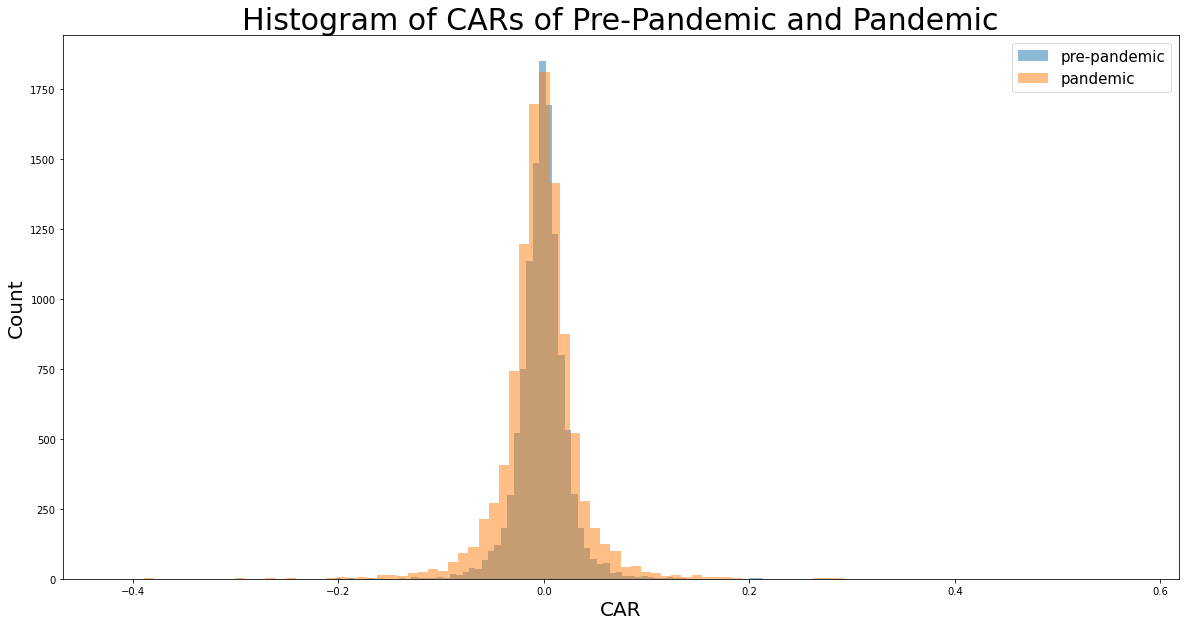

In [60]:
# ignore this approach for now, also because the sample lengths are different
ttest_results = []
ttest_index = []
from IPython.display import clear_output
for type_ in types_of_interest:
    for cp in CAR_periods.keys():

        print(type_)
        print(cp)

        left, right = investigation_periods["Pre-Pandemic"]
        l_CAR, r_CAR = CAR_periods[cp]

        AR_prepandemic = df_abnormal_returns.loc[:,:,type_,left:right].values

        sample_CAR_prepandemic = AR_prepandemic[:,l_CAR:(r_CAR+1)].sum(axis=1)
        # sample_CAR_prepandemic = R_market_event_window_prepandemic[:,l_CAR:(r_CAR+1)].cumsum(axis=1).mean(axis=0) ### TODO WAIT AUSSENEGG ANSWER HOW TO AGGREGATE FOR TTEST

        left, right = investigation_periods["Pandemic"]

        AR_pandemic = df_abnormal_returns.loc[:,:,type_,left:right].values
        sample_CAR_pandemic = AR_pandemic[:,l_CAR:(r_CAR+1)].sum(axis=1)
        # sample_CAR_pandemic = R_market_event_window_pandemic[:,l_CAR:(r_CAR+1)].cumsum(axis=1).mean(axis=0) ### TODO WAIT AUSSENEGG ANSWER HOW TO AGGREGATE FOR TTEST
        # import ttest

        ttest = ttest_ind(sample_CAR_pandemic, sample_CAR_prepandemic)

        #test_results.append((grank_result.pvalue, grank_result.statistic, adj_grank_result.pvalue, adj_grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
        ttest_results.append((ttest.pvalue, ttest.statistic))
        ttest_index.append((type_, cp))


        fig = plt.figure(figsize=(fig_height, 10))
        plt.hist(sample_CAR_prepandemic,bins = 100, alpha = 0.5)
        plt.hist(sample_CAR_pandemic,bins = 100, alpha = 0.5)
        plt.legend(["pre-pandemic", "pandemic"], fontsize = tick_size)
        plt.xlabel("CAR", fontsize=label_size)
        plt.ylabel("Count", fontsize=label_size)
        plt.title("Histogram of CARs of Pre-Pandemic and Pandemic", fontsize=title_size)
        plt.savefig(f"data/{NAME}/visualisations/histogram_CARs_pp_p_{type_}_{cp}.svg")

        clear_output(wait=True)
        plt.show()

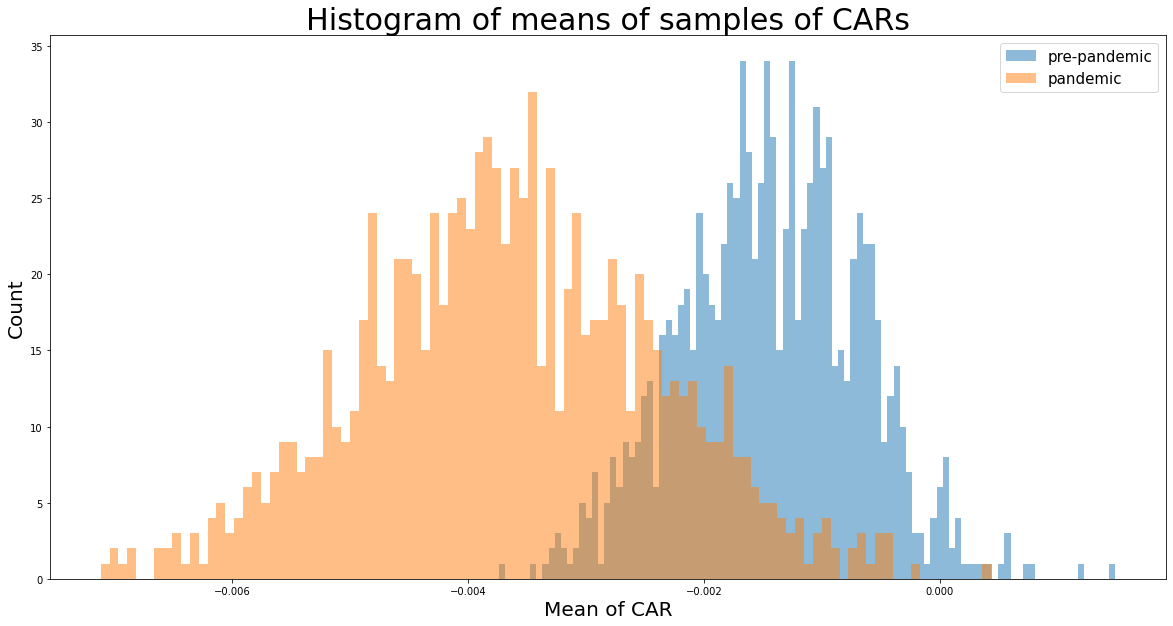

In [61]:
# approach recommended by Aussenegg: Simulate mean differences
ttest_results = []
ttest_index = []

for type_ in types_of_interest:
    for cp in CAR_periods.keys():

        print(type_)
        print(cp)
        l_CAR, r_CAR = CAR_periods[cp]

        left, right = investigation_periods["Pre-Pandemic"]
        AR_prepandemic = df_abnormal_returns.loc[:,:,type_,left:right].values
        sample_CAR_prepandemic = AR_prepandemic[:,l_CAR:(r_CAR+1)].sum(axis=1)

        left, right = investigation_periods["Pandemic"]
        AR_pandemic = df_abnormal_returns.loc[:,:,type_,left:right].values
        sample_CAR_pandemic = AR_pandemic[:,l_CAR:(r_CAR+1)].sum(axis=1)


        CAAR_pp = sample_CAR_prepandemic.mean()
        CAAR_p = sample_CAR_pandemic.mean()
        CAAR_diff = CAAR_p - CAAR_pp

        sample_size = 1000
        diffs = []
        subsample_means_CAR_prepandemic = []
        subsample_means_CAR_pandemic = []
        for i in range(1000):
            # pick subsample
            subsample_pp = np.random.choice(sample_CAR_prepandemic, sample_size, replace=True)
            subsample_p = np.random.choice(sample_CAR_pandemic, sample_size, replace=True)
            diff = subsample_p-subsample_pp
            subsample_means_CAR_prepandemic.append(subsample_pp.mean())
            subsample_means_CAR_pandemic.append(subsample_p.mean())
            diffs.append(diff.mean())



        fig = plt.figure(figsize=(fig_height, 10))
        plt.hist(subsample_means_CAR_prepandemic,bins = 100, alpha = 0.5)
        plt.hist(subsample_means_CAR_pandemic,bins = 100, alpha = 0.5)
        plt.legend(["pre-pandemic", "pandemic"], fontsize = tick_size)
        plt.xlabel("Mean of CAR", fontsize=label_size)
        plt.ylabel("Count", fontsize=label_size)

        plt.title("Histogram of means of samples of CARs", fontsize=title_size)
        plt.savefig(f"data/{NAME}/visualisations/histogram_mean_CARs_pp_p_{type_}_{cp}.svg")

        clear_output(wait=True)
        plt.show()

        ttest = stats.ttest_1samp(diffs, 0)

        #test_results.append((grank_result.pvalue, grank_result.statistic, adj_grank_result.pvalue, adj_grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
        ttest_results.append((CAAR_diff, ttest.pvalue, ttest.statistic))
        ttest_index.append((type_, cp))

In [62]:
ttest_df = pd.DataFrame(ttest_results, index=pd.MultiIndex.from_tuples(ttest_index, names=["Trade Type", "CAR period"]))
ttest_df.columns = ["Δ CAAR", "p-value", "t-statistic"]
print(ttest_df.round(10).to_latex())

\begin{tabular}{llrrr}
\toprule
            &        &    Δ CAAR &  p-value &  t-statistic \\
Trade Type & CAR period &           &          &              \\
\midrule
P - Purchase & [-20, -1] & -0.042287 &      0.0 &  -149.874303 \\
            & [0, 20] & -0.008325 &      0.0 &   -35.697691 \\
            & [0, 5] &  0.004553 &      0.0 &    28.182590 \\
            & [0, 1] &  0.004300 &      0.0 &    37.468412 \\
S - Sale & [-20, -1] &  0.004974 &      0.0 &    27.617163 \\
            & [0, 20] & -0.009126 &      0.0 &   -52.613505 \\
            & [0, 5] & -0.003812 &      0.0 &   -44.039931 \\
            & [0, 1] & -0.001630 &      0.0 &   -31.256166 \\
S - Sale+OE & [-20, -1] &  0.002011 &      0.0 &    12.976471 \\
            & [0, 20] & -0.014168 &      0.0 &   -95.755380 \\
            & [0, 5] & -0.005569 &      0.0 &   -73.158788 \\
            & [0, 1] & -0.002207 &      0.0 &   -47.836320 \\
\bottomrule
\end{tabular}



C:\Users\Tom\AppData\Local\Temp\ipykernel_11368\1073576094.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ttest_df.round(10).to_latex())


In [63]:
test_results = []
test_index = []

for per in investigation_periods.keys():
    for type_ in types_of_interest:
        for CAR_period_name in CAR_periods.keys():

            print(per)
            print(type_)
            print(CAR_period_name)
            CAR_period = CAR_periods[CAR_period_name]

            left, right = investigation_periods[per]
            AR = df_abnormal_returns.loc[:,:,type_, left:right].values
            eps = df_eps.loc[:,:,type_,left:right].values
            R_market_estimation_window = df_estimation_window_market_return.loc[:,:,type_,left:right].values
            R_market_event_window = df_event_window_market_return.loc[:,:,type_,left:right].values
            grank_result = grank(AR, eps, R_market_estimation_window, R_market_event_window, CAR_period, False)
            adj_grank_result = grank(AR, eps, R_market_estimation_window, R_market_event_window, CAR_period, True)
            adjBMP_result = adjBMP(AR, eps, R_market_estimation_window, R_market_event_window, CAR_period)
            CAAR = AR[:,CAR_period[0]:(CAR_period[1]+1)].sum(axis=1).mean() # scalar value
            test_results.append((CAAR, grank_result.pvalue, grank_result.statistic, adj_grank_result.pvalue, adj_grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
            #test_results.append((grank_result.pvalue, grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
            test_index.append((per, type_, CAR_period_name))

Overall
P - Purchase
[-20, -1]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
P - Purchase
[0, 20]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
P - Purchase
[0, 5]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
P - Purchase
[0, 1]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale
[-20, -1]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale
[0, 20]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale
[0, 5]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale
[0, 1]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale+OE
[-20, -1]
Too many events to calculate average cross correlation, subsampling combinations..

In [64]:
test_results_df = pd.DataFrame(test_results, index=pd.MultiIndex.from_tuples(test_index, names=["Investigation Period", "Trade Type", "CAR Period"]))
test_results_df.columns = ["CAAR", "GRANK p-value", "GRANK t-statistic", "adj-GRANK p-value", "adj-GRANK statistic", "adjBMP p-value", "adjBMP t-statistic"]

In [65]:
test_results_df.to_pickle(f"data/{NAME}/statistical_tests/GRANK_ADJBMP.pkl")

In [66]:
test_results_df.to_excel(f"data/{NAME}/statistical_tests/statistical_tests_results.xlsx")

#### Export information to latex

In [67]:
test_results_df

CAAR  GRANK p-value  \
Investigation Period Trade Type   CAR Period                            
Overall              P - Purchase [-20, -1]   0.077385   5.833511e-02   
                                  [0, 20]    -0.005977   2.997378e-10   
                                  [0, 5]     -0.009819   3.317897e-05   
                                  [0, 1]      0.003000   1.011039e-05   
                     S - Sale     [-20, -1]  -0.032329   2.132384e-33   
                                  [0, 20]     0.036342   1.013926e-24   
                                  [0, 5]     -0.013210   1.238050e-13   
                                  [0, 1]     -0.024994   1.801343e-16   
                     S - Sale+OE  [-20, -1]   0.025806   5.136476e-39   
                                  [0, 20]    -0.010390   8.946540e-23   
                                  [0, 5]     -0.012944   2.818689e-12   
                                  [0, 1]     -0.045113   5.249924e-09   
Pre-Pandemic         P - Purchase [-20, -1]   0.048213   7.666704e-01   
                                  [0, 20]    -0.005548   1.795706e-09   
                                  [0, 5]      0.132872   6.018937e-09   
                                  [0, 1]      0.148614   1.111003e-07   
                     S - Sale     [-20, -1]   0.018707   4.133503e-26   
                                  [0, 20]     0.031921   1.466286e-16   
                                  [0, 5]      0.038616   7.133243e-10   
                                  [0, 1]      0.120199   1.236136e-12   
                     S - Sale+OE  [-20, -1]  -0.008922   1.271813e-30   
                                  [0, 20]     0.025795   1.651701e-10   
                                  [0, 5]      0.046184   1.658013e-05   
                                  [0, 1]      0.028490   1.833175e-04   
Pandemic             P - Purchase [-20, -1]   0.080700   6.283316e-07   
                                  [0, 20]    -0.005636   3.428394e-08   
                                  [0, 5]     -0.036300   1.562303e-05   
                                  [0, 1]      0.004316   1.300043e-05   
                     S - Sale     [-20, -1]  -0.032329   1.602725e-20   
                                  [0, 20]     0.039562   2.453882e-16   
                                  [0, 5]     -0.013210   1.924720e-06   
                                  [0, 1]     -0.024994   1.011853e-07   
                     S - Sale+OE  [-20, -1]   0.034277   9.030852e-27   
                                  [0, 20]     0.041303   5.070929e-22   
                                  [0, 5]      0.079557   3.159783e-10   
                                  [0, 1]      0.082861   6.854096e-07   

                                              GRANK t-statistic  \
Investigation Period Trade Type   CAR Period                      
Overall              P - Purchase [-20, -1]           -1.915339   
                                  [0, 20]              7.006756   
                                  [0, 5]               4.349520   
                                  [0, 1]               4.653987   
                     S - Sale     [-20, -1]           18.224638   
                                  [0, 20]            -13.762405   
                                  [0, 5]              -8.597605   
                                  [0, 1]              -9.900719   
                     S - Sale+OE  [-20, -1]           21.460210   
                                  [0, 20]            -12.828809   
                                  [0, 5]              -7.967404   
                                  [0, 1]              -6.398308   
Pre-Pandemic         P - Purchase [-20, -1]            0.297550   
                                  [0, 20]              6.628509   
                                  [0, 5]               6.368760   
                                  [0, 1]               5.724691   
                     S - Sale     [-20, -1]           14.441830   
  